In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
! kaggle competitions download -c house-prices-advanced-regression-techniques

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 60.6MB/s]


In [6]:
!unzip /content/house-prices-advanced-regression-techniques.zip

Archive:  /content/house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [7]:
import pandas as pd
import torch
from torch import nn
import numpy as np

In [8]:
test_df = pd.read_csv('/content/test.csv')
train_df = pd.read_csv('/content/train.csv')

In [17]:
label = 'SalePrice'
features = pd.concat([train_df.drop(columns=['Id', label]), test_df.drop(columns=['Id'])])
numeric_features = features.dtypes[features.dtypes!='object'].index
features[numeric_features] = features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
features[numeric_features] = features[numeric_features].fillna(0)
features = pd.get_dummies(features, dummy_na=True)
train = features[:train_df.shape[0]].copy()
train[label] = train_df[label]
test = features[train_df.shape[0]:].copy()
train = train.to_numpy()
test = test.to_numpy()
target_variable = train_df[label].to_numpy()

In [11]:
def get_dataloader(self, train):
    label = 'SalePrice'
    data = self.train if train else self.val
    if label not in data: return
    get_tensor = lambda x: torch.tensor(x.values.astype(float),
                                      dtype=torch.float32)
    # Logarithm of prices
    tensors = (get_tensor(data.drop(columns=[label])),  # X
               torch.log(get_tensor(data[label])).reshape((-1, 1)))  # Y
    return self.get_tensorloader(tensors, train)

In [12]:
import numpy as np

def get_kfold_data(k, i, X, y):
  """
  Returns the training and validation data for the ith fold in a K-fold cross-validation.

  Args:
    k: The total number of folds.
    i: The current fold index (starting from 0).
    X: The feature data (NumPy array or pandas DataFrame).
    y: The target variable data (NumPy array or pandas Series).

  Returns:
    A tuple containing the training data (X_train, y_train) and validation data (X_valid, y_valid).
  """
  assert k > 1, "k must be greater than 1"
  assert 0 <= i < k, "i must be in the range [0, k)"

  fold_size = X.shape[0] // k  # Calculate the size of each fold

  # Calculate the start and end indices for the validation fold
  val_start = i * fold_size
  val_end = (i + 1) * fold_size if i < k - 1 else X.shape[0]

  # Create boolean masks for training and validation data
  val_mask = np.zeros(X.shape[0], dtype=bool)
  val_mask[val_start:val_end] = True
  train_mask = ~val_mask

  # Split the data using the masks
  X_train, y_train = X[train_mask], y[train_mask]
  X_valid, y_valid = X[val_mask], y[val_mask]

  return X_train, y_train, X_valid, y_valid

In [18]:
k = 5  # Number of folds
i = 0  # Current fold index (0 for the first fold)
X_train, y_train, X_valid, y_valid = get_kfold_data(k, i, train, target_variable)

In [25]:
def kfold_cross_validation(k, X, y, train_and_validate_model):
    train_losses = []
    validation_losses = []

    for i in range(k):
        X_train, y_train, X_valid, y_valid = get_kfold_data(k, i, X, y)

        train_loss, validation_loss = train_and_validate_model(X_train, y_train, X_valid, y_valid)

        train_losses.append(train_loss)
        validation_losses.append(validation_loss)

    # ... (rest of the function remains the same)

    return train_losses, validation_losses  # Return both loss lists

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def train_and_validate_model(X_train, y_train, X_valid, y_valid):
    model = LinearRegression()
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)  # Predictions on training data
    y_valid_pred = model.predict(X_valid)  # Predictions on validation data

    train_loss = np.sqrt(mean_squared_error(y_train, y_train_pred))  # Training loss
    validation_loss = np.sqrt(mean_squared_error(y_valid, y_valid_pred))  # Validation loss

    return train_loss, validation_loss # Return both losses

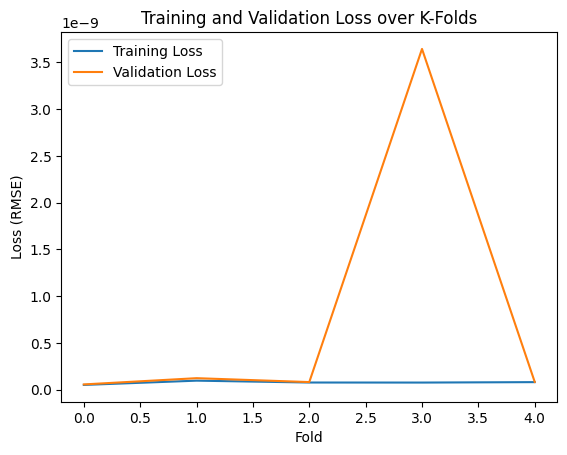

In [26]:
import matplotlib.pyplot as plt

# Assuming you have your data in 'train' (features) and 'y' (target)
train_losses, validation_losses = kfold_cross_validation(k, train, target_variable, train_and_validate_model)

plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Fold')
plt.ylabel('Loss (RMSE)')
plt.title('Training and Validation Loss over K-Folds')
plt.legend()
plt.show()

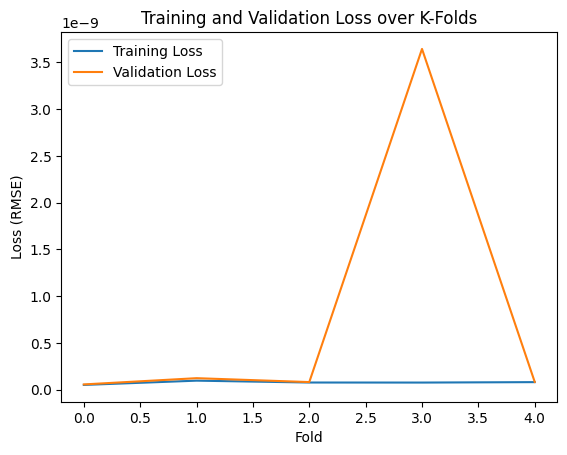